In [ ]:
!pip install -q kaggle
import pandas as pd
import matplotlib.pyplot as plt
import math, random

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bipinmaharjan/xor-dataset
!unzip -o xor-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/bipinmaharjan/xor-dataset
License(s): unknown
Archive:  xor-dataset.zip
  inflating: Xor_Dataset.csv         


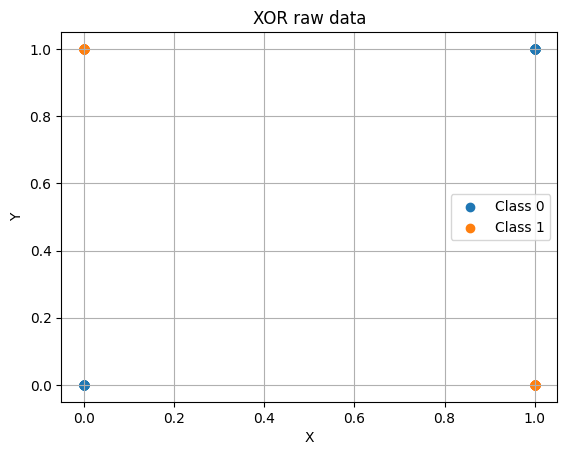

In [ ]:
data = pd.read_csv("Xor_Dataset.csv")

x= data[["X", "Y"]].values
y= data["Z"].values
N=len(x)

# Manually defined XOR dataset (20 samples)
for lable in [0,1]:
  plt.scatter(x[y==lable][:, 0],x[y== lable][:, 1], label=f"Class {lable}")

plt.title("XOR raw data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

# KERNEL TRICK USING QUADRATIC FUNCTION {[aT b]**2}

✨ Training accuracy: 76.6% ✨


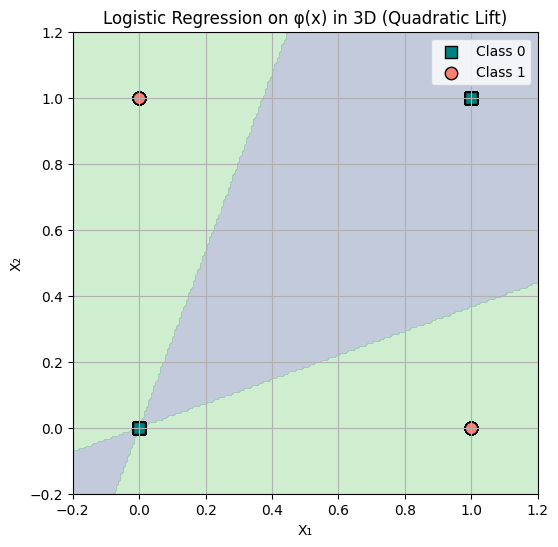

In [ ]:
# ─── Lift to 3D: φ(x) = [x1^2, x2^2, √2·x1·x2] ────────────────────────────
def phi(pt):
    x1, x2 = pt
    return [x1*x1, x2*x2, math.sqrt(2)*x1*x2]

X3d = [phi(pt) for pt in x]

# ─── Helpers ───────────────────────────────────────────────────────────────
def sigmoid(z):
    if z < -100: return 0.0
    if z >  100: return 1.0
    return 1.0 / (1.0 + math.exp(-z))

def dot(u, v):
    return sum(ui*vi for ui, vi in zip(u, v))

# ─── Train logistic regression in 3D ───────────────────────────────────────
def train_logistic(X, y, lr=0.1, epochs=500):
    D = len(X[0])
    w = [random.uniform(-0.5, 0.5) for _ in range(D)]
    for _ in range(epochs):
        for xi, yi in zip(X, y):
            z    = dot(w, xi)
            pred = sigmoid(z)
            err  = pred - yi
            for j in range(D):
                w[j] -= lr * err * xi[j]
    return w

w = train_logistic(X3d, y, lr=0.2, epochs=300)

# ─── Predict & accuracy ───────────────────────────────────────────────────
def predict_one(pt2d, w):
    feat = phi(pt2d)
    return 1 if sigmoid(dot(w, feat)) >= 0.5 else 0

y_pred = [predict_one(pt, w) for pt in x]
accuracy = sum(yt==yp for yt, yp in zip(y, y_pred)) / N
print(f"✨ Training accuracy: {accuracy*100:.1f}% ✨")

# ─── Plot decision boundary back in 2D ────────────────────────────────────
# grid over [min-0.2, max+0.2]
xs = [pt[0] for pt in x]
ys = [pt[1] for pt in x]
xmin, xmax = min(xs)-0.2, max(xs)+0.2
ymin, ymax = min(ys)-0.2, max(ys)+0.2

nx, ny = 200, 200
xx = [xmin + i*(xmax-xmin)/(nx-1) for i in range(nx)]
yy = [ymin + j*(ymax-ymin)/(ny-1) for j in range(ny)]

Z = []
for xg in xx:
    row = []
    for yg in yy:
        row.append(predict_one([xg, yg], w))
    Z.append(row)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5], alpha=0.3)

for cls, marker, color in zip([0,1], ['s','o'], ['teal','salmon']):
    pts = [x[i] for i in range(N) if y[i]==cls]
    plt.scatter([p[0] for p in pts], [p[1] for p in pts],
                marker=marker, color=color, edgecolor='k', s=80,
                label=f"Class {cls}")

plt.title("Logistic Regression on φ(x) in 3D (Quadratic Lift)")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.show()

# KERNAL USING POLYNOMIAL FUNCTION = (a T b+c)**d

 Training accuracy: 100.0% 


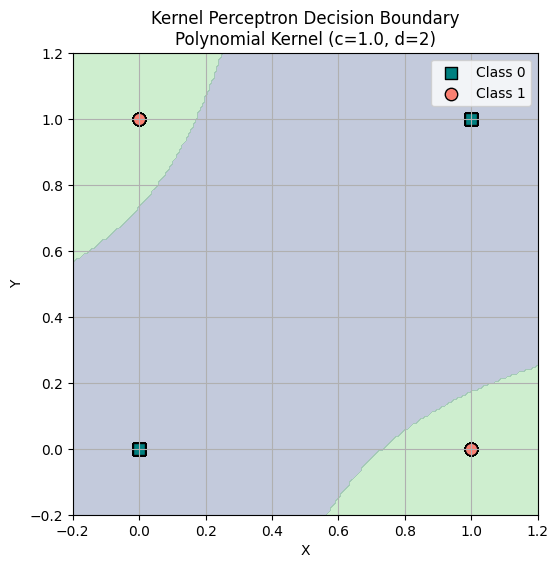

In [ ]:
# ─── XOR data ─────────────────────────────────────────────────────────
import pandas as pd

# Load data
data = pd.read_csv("Xor_Dataset.csv")

# Features
x = data[["X", "Y"]].values

# Labels — map 0→-1, 1→+1
y_raw = data["Z"].values
y = [1 if yi == 1 else -1 for yi in y_raw]

# Sample size
N = len(x)
# ─── Helpers: dot product & general polynomial kernel ──────────────────────
def dot(u, v):
    return sum(ui*vi for ui, vi in zip(u, v))

def poly_kernel(u, v, c=1.0, d=2):
    """
    Polynomial kernel K(u,v) = (u·v + c)^d
    c = offset (coef0), d = degree
    """
    return (dot(u, v) + c)**d

# ─── Train kernel perceptron (dual form) ───────────────────────────────────
def train_kernel_perceptron(x, y, c=1.0, d=2, epochs=20):
    N = len(x)
    alpha = [0.0]*N
    # Precompute K[i][j]
    K = [[poly_kernel(x[i], x[j], c, d) for j in range(N)] for i in range(N)]
    b = 0.0
    for _ in range(epochs):
        for i in range(N):
            # decision function f(x_i)
            f_i = sum(alpha[j]*y[j]*K[j][i] for j in range(N)) + b
            if y[i]*f_i <= 0:
                alpha[i] += 1.0
                b += y[i]
    return alpha, b

# Set your kernel parameters:
c = 1.0   # bias term in kernel
d = 2     # degree of polynomial

alpha, b = train_kernel_perceptron(x, y, c=c, d=d, epochs=30)

# ─── Prediction function ───────────────────────────────────────────────────
def predict(pt, x, y, alpha, b, c=1.0, d=2):
    s = 0.0
    for j in range(len(x)):
        s += alpha[j]*y[j]*poly_kernel(x[j], pt, c, d)
    s += b
    return 1 if s > 0 else -1

# ─── Compute training accuracy ─────────────────────────────────────────────
preds = [predict(pt, x, y, alpha, b, c, d) for pt in x]
accuracy = sum(1 for i in range(N) if preds[i]==y[i]) / N
print(f" Training accuracy: {accuracy*100:.1f}% ")

# ─── Plot decision boundary + data ─────────────────────────────────────────
# grid limits
xs = [pt[0] for pt in x]
ys = [pt[1] for pt in x]
xmin, xmax = min(xs)-0.2, max(xs)+0.2
ymin, ymax = min(ys)-0.2, max(ys)+0.2

# sample grid
res = 200
xx = [xmin + i*(xmax-xmin)/(res-1) for i in range(res)]
yy = [ymin + j*(ymax-ymin)/(res-1) for j in range(res)]
Z = [[predict([xg, yg], x, y, alpha, b, c, d) for yg in yy] for xg in xx]

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, levels=[-1,0,1], alpha=0.3)

# scatter original points
for lbl, marker, color in zip([-1,1], ['s','o'], ['teal','salmon']):
    pts = [x[i] for i in range(N) if y[i]==lbl]
    plt.scatter([p[0] for p in pts],
                [p[1] for p in pts],
                marker=marker, color=color,
                edgecolor='k', s=80,
                label=f"Class {1 if lbl==1 else 0}")

plt.title(f"Kernel Perceptron Decision Boundary\nPolynomial Kernel (c={c}, d={d})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

# KERNEL USING RBF


 Training accuracy: 100.0% 


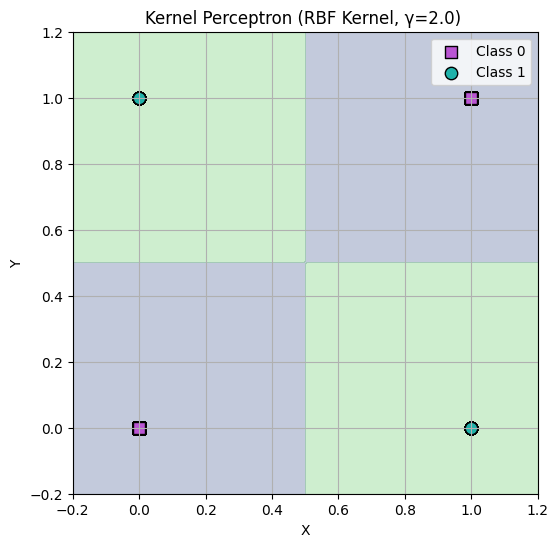

In [ ]:
# ─── XOR-like Data ─────────────────────────────────────────────────────────
import pandas as pd

# Load data
data = pd.read_csv("Xor_Dataset.csv")

# Features
x = data[["X", "Y"]].values

# Labels — map 0→-1, 1→+1
y_raw = data["Z"].values
y = [1 if yi == 1 else -1 for yi in y_raw]

# Sample size
N = len(x)

# ─── RBF Kernel Definition ─────────────────────────────────────────────────
def rbf_kernel(u, v, gamma=1.0):
    dist_sq = sum((ui - vi)**2 for ui, vi in zip(u, v))
    return math.exp(-gamma * dist_sq)

# ─── Training Kernel Perceptron ────────────────────────────────────────────
def train_kernel_perceptron(x, y, gamma=1.0, epochs=20):
    N = len(x)
    alpha = [0.0]*N
    K = [[rbf_kernel(x[i], x[j], gamma) for j in range(N)] for i in range(N)]
    b = 0.0
    for _ in range(epochs):
        for i in range(N):
            f_i = sum(alpha[j]*y[j]*K[j][i] for j in range(N)) + b
            if y[i]*f_i <= 0:
                alpha[i] += 1.0
                b += y[i]
    return alpha, b

# ─── Prediction ────────────────────────────────────────────────────────────
def predict(pt, x, y, alpha, b, gamma=1.0):
    s = sum(alpha[j]*y[j]*rbf_kernel(x[j], pt, gamma) for j in range(len(x)))
    return 1 if s + b > 0 else -1

# ─── Train it ──────────────────────────────────────────────────────────────
gamma = 2.0  # you can tune this value for more/less flexibility
alpha, b = train_kernel_perceptron(x, y, gamma=gamma, epochs=30)

# ─── Accuracy Check ────────────────────────────────────────────────────────
preds = [predict(pt, x, y, alpha, b, gamma) for pt in x]
accuracy = sum(1 for i in range(N) if preds[i]==y[i]) / N
print(f" Training accuracy: {accuracy*100:.1f}% ")

# ─── Visualization ─────────────────────────────────────────────────────────
xs = [pt[0] for pt in x]
ys = [pt[1] for pt in x]
xmin, xmax = min(xs)-0.2, max(xs)+0.2
ymin, ymax = min(ys)-0.2, max(ys)+0.2

res = 200
xx = [xmin + i*(xmax-xmin)/(res-1) for i in range(res)]
yy = [ymin + j*(ymax-ymin)/(res-1) for j in range(res)]
Z = [[predict([xg, yg], x, y, alpha, b, gamma) for yg in yy] for xg in xx]

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, levels=[-1,0,1], alpha=0.3)

for lbl, marker, color in zip([-1,1], ['s','o'], ['mediumorchid','lightseagreen']):
    pts = [x[i] for i in range(N) if y[i]==lbl]
    plt.scatter([p[0] for p in pts],
                [p[1] for p in pts],
                marker=marker, color=color,
                edgecolor='k', s=80,
                label=f"Class {1 if lbl==1 else 0}")

plt.title(f"Kernel Perceptron (RBF Kernel, γ={gamma}) ")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()